# Melanama Detection Assignment

## Problem statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data

#### To do: Take necessary actions to read the data


### Importing all the important libraries


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization




In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
#using when running from google colab

from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("images/Train")
data_dir_test = pathlib.Path('images/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

Define some parameters for the loader:


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

#### Todo, create a code to visualize one instance of all the nine classes present in the dataset


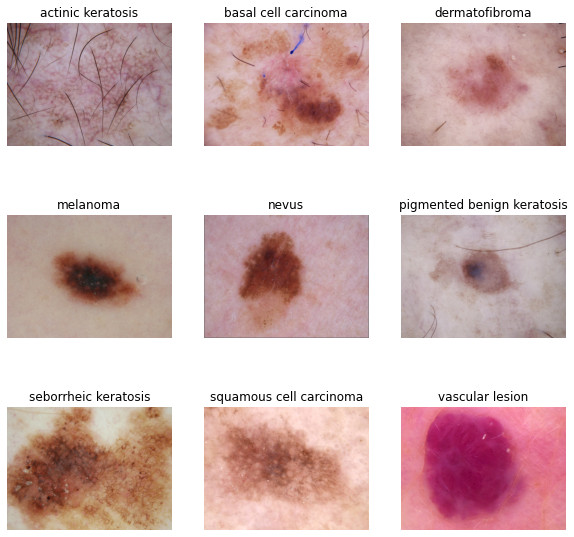

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`


In [ ]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model

Choose an appropirate optimiser and loss function for model training


In [ ]:
### Todo, choose an appropirate optimiser and loss function

opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model


In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 335ms/step - loss: 1.9660 - accuracy: 0.2801 - val_loss: 1.7464 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - 15s 262ms/step - loss: 1.6068 - accuracy: 0.4202 - val_loss: 1.5892 - val_accuracy: 0.4474
Epoch 3/20
56/56 [==============================] - 15s 260ms/step - loss: 1.5046 - accuracy: 0.4509 - val_loss: 1.4433 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 15s 260ms/step - loss: 1.3712 - accuracy: 0.5251 - val_loss: 1.4783 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 15s 262ms/step - loss: 1.2722 - accuracy: 0.5558 - val_loss: 1.3355 - val_accuracy: 0.5526
Epoch 6/20
56/56 [==============================] - 15s 261ms/step - loss: 1.1930 - accuracy: 0.5742 - val_loss: 1.4627 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 15s 259ms/step - loss: 1.0356 - accuracy: 0.6417 - val_loss: 1.5197 - val_accuracy: 0.5190

### Visualizing training results


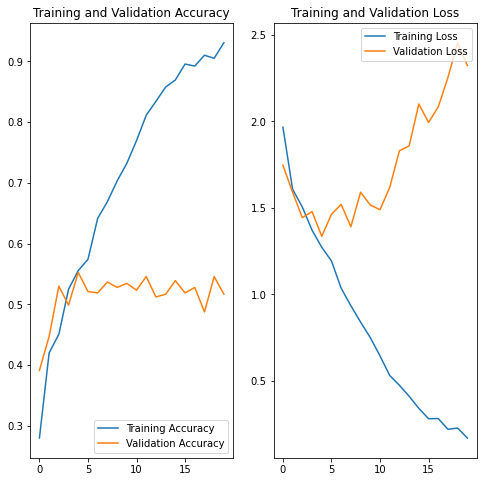

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


**Findings**

1. The Traing accuracy and validation accuracy got huge dfference , validation_accuracy is very low compared to train accuracy which indicates that the model is overfitting
2. Training & validation loss got high difference and validation loss is fluctuating.

Thus we can infer that the model is not good.


In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

# After we visualized the model fit history for presence of underfit or overfit, we choose an
# augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

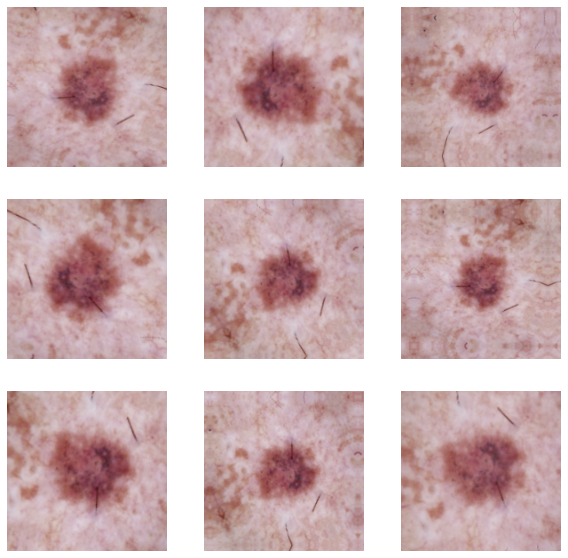

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:

### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model


In [ ]:
### Todo, choose an appropirate optimiser and loss function

opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

### Training the model


In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 191s 3s/step - loss: 2.1431 - accuracy: 0.2377 - val_loss: 1.9087 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 221s 4s/step - loss: 1.8142 - accuracy: 0.3443 - val_loss: 1.8184 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 206s 4s/step - loss: 1.6730 - accuracy: 0.4057 - val_loss: 1.5895 - val_accuracy: 0.4653
Epoch 4/20
56/56 [==============================] - 203s 4s/step - loss: 1.6042 - accuracy: 0.4213 - val_loss: 1.5482 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 198s 4s/step - loss: 1.5280 - accuracy: 0.4503 - val_loss: 1.4461 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 213s 4s/step - loss: 1.4316 - accuracy: 0.4911 - val_loss: 1.5696 - val_accuracy: 0.4430
Epoch 7/20
56/56 [==============================] - 201s 4s/step - loss: 1.4120 - accuracy: 0.4927 - val_loss: 1.3988 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing the results


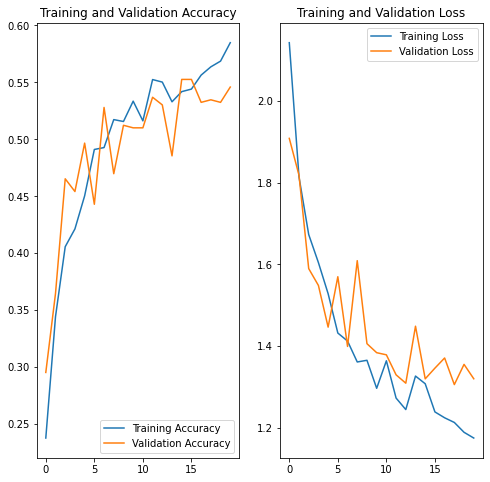

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings**

1. The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.


#### **Todo:** Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,images\Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,images\Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,images\Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,images\Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,images\Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,images\Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,images\Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,images\Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,images\Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


In [ ]:
# Identify the 9 classes of images

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


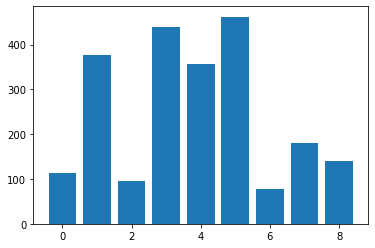

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
# Identify the class names

In [ ]:
dfs = []

# Inside your loop where you are appending DataFrames
for i in range(len(class_names)):
   name= class_names[i]
   number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
   class_diff = pd.DataFrame({'class': [name], 'number': [number]})
   dfs.append(class_diff)

# Concatenate the list of DataFrames into a single DataFrame
class_diff = pd.concat(dfs, ignore_index=True)

class_diff

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

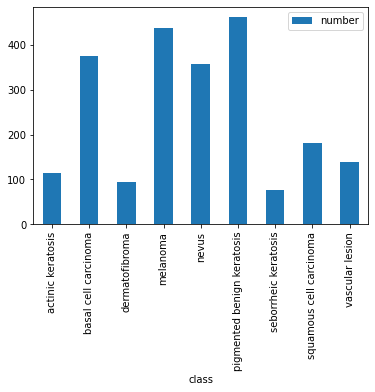

In [ ]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

**Findings**

#### - Which class has the least number of samples?

Ans.** seborrheic keratosis (77)

#### - Which classes dominate the data in terms proportionate number of samples?

Ans.** pigmented benign keratosis (462)


#### **Todo:** Rectify the class imbalance

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


In [ ]:
!pip install Augmentor

Defaulting to user installation because normal site-packages is not writeable


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [ ]:
path_to_training_dataset="images/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to images/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x267BEADFD00>: 100%|█| 500/500 [00:11<00:


Initialised with 376 image(s) found.
Output directory set to images/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x267BEB042B0>: 100%|█| 500/500 [00:11<00:00, 43.33 Samples/


Initialised with 95 image(s) found.
Output directory set to images/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x267BDE0A700>: 100%|█| 500/500 [00:12<00:00, 41.31 Samples/


Initialised with 438 image(s) found.
Output directory set to images/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x267BEAA5430>: 100%|█| 500/500 [00:55<00:00,  8.98 Samples


Initialised with 357 image(s) found.
Output directory set to images/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x267BEB0FAC0>: 100%|█| 500/500 [00:53<00:00,  9.41 Samples/


Initialised with 462 image(s) found.
Output directory set to images/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x267BEA5E8E0>: 100%|█| 500/500 [00:11<00:00, 42.08 Samples/


Initialised with 77 image(s) found.
Output directory set to images/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x267C4476190>: 100%|█| 500/500 [00:27<00:00, 17.92 Samples


Initialised with 181 image(s) found.
Output directory set to images/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x267BEAAD1F0>: 100%|█| 500/500 [00:12<00:


Initialised with 139 image(s) found.
Output directory set to images/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x267C34E8E50>: 100%|█| 500/500 [00:11<00:00, 42.29 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

8000


### Lets see the distribution of augmented data after adding new images to the original training data.


In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_13170136-6870-439e-a190-c75dd6ecd11c.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3ce589b3-f26a-4b48-9405-c994dc397e02.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_4aa5a69d-31b0-4df0-b07e-08ef855b8189.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_53c0b801-0175-4ebd-b1e3-0c6c0ac7c7b2.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_712d85ec-64e9-4dbf-be68-f3a2f20ae93f.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_93b1970b-bcb4-45d0-933e-afb8fea91867.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_e31dcdb3-580c-4e7b-b57a-2325ac1d8d7e.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803

In [ ]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_1114738c-c9c3-45db-b01c-3c7f0f02ecbe.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3af4cc74-844a-456c-9c63-98545929d19c.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_42baa54e-fd7d-4e74-8456-76e7ca86496f.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_642790a3-7d54-4d39-b3c9-fe97a5d1003c.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8ad436a2-4c9b-4b4a-a3cc-6cfa35b675a7.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9a2de494-0c85-463a-a5f1-2ef8f4186079.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a6406e77-26c6-4002-a6cc-d0a03f33fc08.jpg',
 'images\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
squamous cell carcinoma        681
vascular lesion                639
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


#### **Todo**: Train the model on the data created using Augmentor


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset


In [ ]:
data_dir_train="images/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10239 files belonging to 9 classes.
Using 8192 files for training.


#### **Todo:** Create a validation dataset


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10239 files belonging to 9 classes.
Using 2047 files for validation.


#### **Todo:** Create your model (make sure to include normalization)


In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)


In [ ]:
### Todo, choose an appropirate optimiser and loss function

opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:** Train your model


In [ ]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
256/256 [==============================] - 487s 2s/step - loss: 2.1389 - accuracy: 0.1620 - val_loss: 1.9209 - val_accuracy: 0.2599
Epoch 2/50
256/256 [==============================] - 450s 2s/step - loss: 1.8605 - accuracy: 0.2524 - val_loss: 1.6725 - val_accuracy: 0.3649
Epoch 3/50
256/256 [==============================] - 443s 2s/step - loss: 1.6794 - accuracy: 0.3304 - val_loss: 1.6346 - val_accuracy: 0.3522
Epoch 4/50
256/256 [==============================] - 444s 2s/step - loss: 1.5699 - accuracy: 0.3787 - val_loss: 1.4595 - val_accuracy: 0.4367
Epoch 5/50
256/256 [==============================] - 442s 2s/step - loss: 1.4817 - accuracy: 0.4126 - val_loss: 1.4353 - val_accuracy: 0.4460
Epoch 6/50
256/256 [==============================] - 443s 2s/step - loss: 1.4380 - accuracy: 0.4338 - val_loss: 1.3131 - val_accuracy: 0.4797
Epoch 7/50
256/256 [==============================] - 444s 2s/step - loss: 1.3765 - accuracy: 0.4573 - val_loss: 1.2174 - val_accuracy: 0.5217

#### **Todo:** Visualize the model results


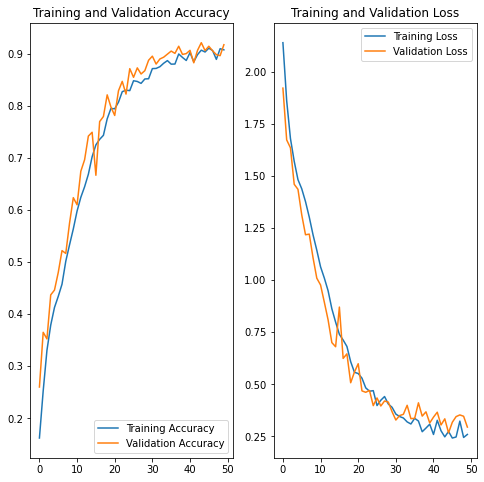

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


**Findings**
1. The training accuracy and validation accuracy are almost same. This is a sign of good fit.
2. The training loss and validation loss are almost same. This is a sign of good fit.
3. The Validation accuracy is 0.91 which is good. The model is able to classify the images with 91% accuracy.

### Test the model

1/1 [==============================] - 0s 280ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


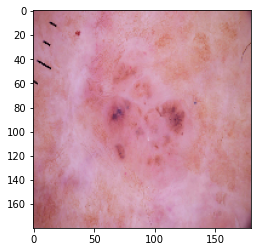

In [ ]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)